In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

# Cargar datos
file_path_hogar = '../../../../data/processed/datos_consumo/hogar_individual_bcn/casa_bcn_clean.csv'
df = pd.read_csv(file_path_hogar)

c:\Users\anaig\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Convertir timestamp a datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')

# Crear características temporales
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.weekday
df['hour'] = df['timestamp'].dt.hour
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

In [3]:
# Cargar festivos
festivos = [
    "2017-01-06", "2017-04-14", "2017-04-17", "2017-05-01", "2017-06-05", "2017-06-24",
    "2017-08-15", "2017-09-11", "2017-09-25", "2017-10-12", "2017-11-01", "2017-12-06",
    "2017-12-08", "2017-12-25", "2017-12-26", "2018-01-01", "2018-01-06", "2018-03-30",
    "2018-04-02", "2018-05-01", "2018-08-15", "2018-09-11", "2018-10-12", "2018-11-01",
    "2018-12-06", "2018-12-08", "2018-12-25", "2018-12-26", "2019-01-01", "2019-04-19",
    "2019-04-22", "2019-05-01", "2019-06-10", "2019-06-24", "2019-08-15", "2019-09-11",
    "2019-09-24", "2019-10-12", "2019-11-01", "2019-12-06", "2019-12-25", "2019-12-26",
    "2020-01-01", "2020-01-06", "2020-04-10", "2020-04-13", "2020-05-01", "2020-06-01",
    "2020-06-24", "2020-08-15", "2020-09-11", "2020-09-24", "2020-10-12", "2020-12-08",
    "2020-12-25", "2020-12-26"
]
df['is_holiday'] = df['timestamp'].dt.strftime('%Y-%m-%d').isin(festivos).astype(int)


In [5]:
# Normalizar el consumo
scaler = MinMaxScaler(feature_range=(0, 1))
df['consumo_kwh'] = scaler.fit_transform(df[['consumo_kwh']])

# Obtener el consumo mínimo real (para evitar que el modelo prediga valores demasiado bajos)
umbral_min = df[df['consumo_kwh'] > 0]['consumo_kwh'].min()

# Separar entrenamiento y prueba
train = df[df['timestamp'] < '2020-01-01']
test = df[df['timestamp'] >= '2020-01-01']

# Definir características y variable objetivo
features = ['hour', 'weekday', 'is_weekend', 'is_holiday']
target = 'consumo_kwh'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

In [6]:
# Función de optimización con Optuna
def objective(trial):
    params = {
        'objective': 'reg:pseudohubererror',  # Cambio a función de pérdida más robusta
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1, 10),  # Evita predicciones extremas
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)  # Controla la cantidad mínima de datos en nodos hoja
    }
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Aplicar restricción de valores negativos y evitar predicciones de consumo 0
    y_pred = np.clip(y_pred, umbral_min, max(y_pred))

    return mean_squared_error(y_test, y_pred)

In [7]:
# Ejecutar la optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores Hiperparámetros:", best_params)

[I 2025-03-19 19:55:44,429] A new study created in memory with name: no-name-dce357e3-de11-4304-93e2-9291424351be
[I 2025-03-19 19:55:44,588] Trial 0 finished with value: 0.013251969012370923 and parameters: {'n_estimators': 241, 'max_depth': 10, 'learning_rate': 0.14796681223758387, 'subsample': 0.6412590668067826, 'colsample_bytree': 0.7145723672294801, 'gamma': 5.917574450959528, 'reg_alpha': 0.6615404176296849, 'reg_lambda': 0.578096665422133, 'min_child_weight': 3}. Best is trial 0 with value: 0.013251969012370923.
[I 2025-03-19 19:55:45,068] Trial 1 finished with value: 0.013422185498750225 and parameters: {'n_estimators': 876, 'max_depth': 10, 'learning_rate': 0.06181108979586166, 'subsample': 0.935264191893658, 'colsample_bytree': 0.6038718452794888, 'gamma': 8.492312305568525, 'reg_alpha': 0.2705586761594513, 'reg_lambda': 0.5877416914881144, 'min_child_weight': 9}. Best is trial 0 with value: 0.013251969012370923.
[I 2025-03-19 19:55:45,482] Trial 2 finished with value: 0.013

Mejores Hiperparámetros: {'n_estimators': 692, 'max_depth': 9, 'learning_rate': 0.23777721562082565, 'subsample': 0.9749964588863493, 'colsample_bytree': 0.8365388848408978, 'gamma': 1.0005186728405533, 'reg_alpha': 0.8059737999132444, 'reg_lambda': 0.6714611806028272, 'min_child_weight': 5}


In [8]:
# Entrenar el modelo con los mejores parámetros
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# Validación secuencial
rmse_values = []
mae_values = []
predicciones_totales = pd.DataFrame()
errores_previos = []

In [9]:
for dia in pd.date_range(start='2020-01-01', end=df['timestamp'].max(), freq='D'):
    test_dia = df[df['timestamp'].dt.date == dia.date()]
    if test_dia.empty:
        continue

    X_test_dia = test_dia[features]
    y_pred_dia = best_model.predict(X_test_dia)

    # Aplicar restricción para evitar valores negativos y consumo 0
    y_pred_dia = np.clip(y_pred_dia, umbral_min, max(y_pred_dia))

    # Desnormalizar las predicciones
    y_pred_dia = scaler.inverse_transform(y_pred_dia.reshape(-1, 1))

    # Ajuste con error previo
    if len(errores_previos) > 10:
        ajuste_error = np.mean(errores_previos[-10:])
    else:
        ajuste_error = 0

    y_pred_ajustado = np.clip(y_pred_dia + ajuste_error, umbral_min, max(y_pred_dia))  # Ajuste final seguro

    # Calcular errores
    rmse = np.sqrt(mean_squared_error(test_dia['consumo_kwh'], y_pred_ajustado))
    mae = mean_absolute_error(test_dia['consumo_kwh'], y_pred_ajustado)

    rmse_values.append(rmse)
    mae_values.append(mae)

    # Guardar errores previos
    errores_previos.extend(test_dia['consumo_kwh'].values - y_pred_dia.flatten())

    # Guardar predicciones
    df_pred = pd.DataFrame({
        'timestamp': test_dia['timestamp'].values,
        'real': test_dia['consumo_kwh'].values,
        'predicho': y_pred_dia.flatten(),
        'predicho_ajustado': y_pred_ajustado.flatten()
    })
    
    predicciones_totales = pd.concat([predicciones_totales, df_pred])

In [10]:
# Calcular métricas finales
rmse_final = np.mean(rmse_values)
mae_final = np.mean(mae_values)

print(f"RMSE Final: {rmse_final:.2f}")
print(f"MAE Final: {mae_final:.2f}")

RMSE Final: 0.12
MAE Final: 0.09


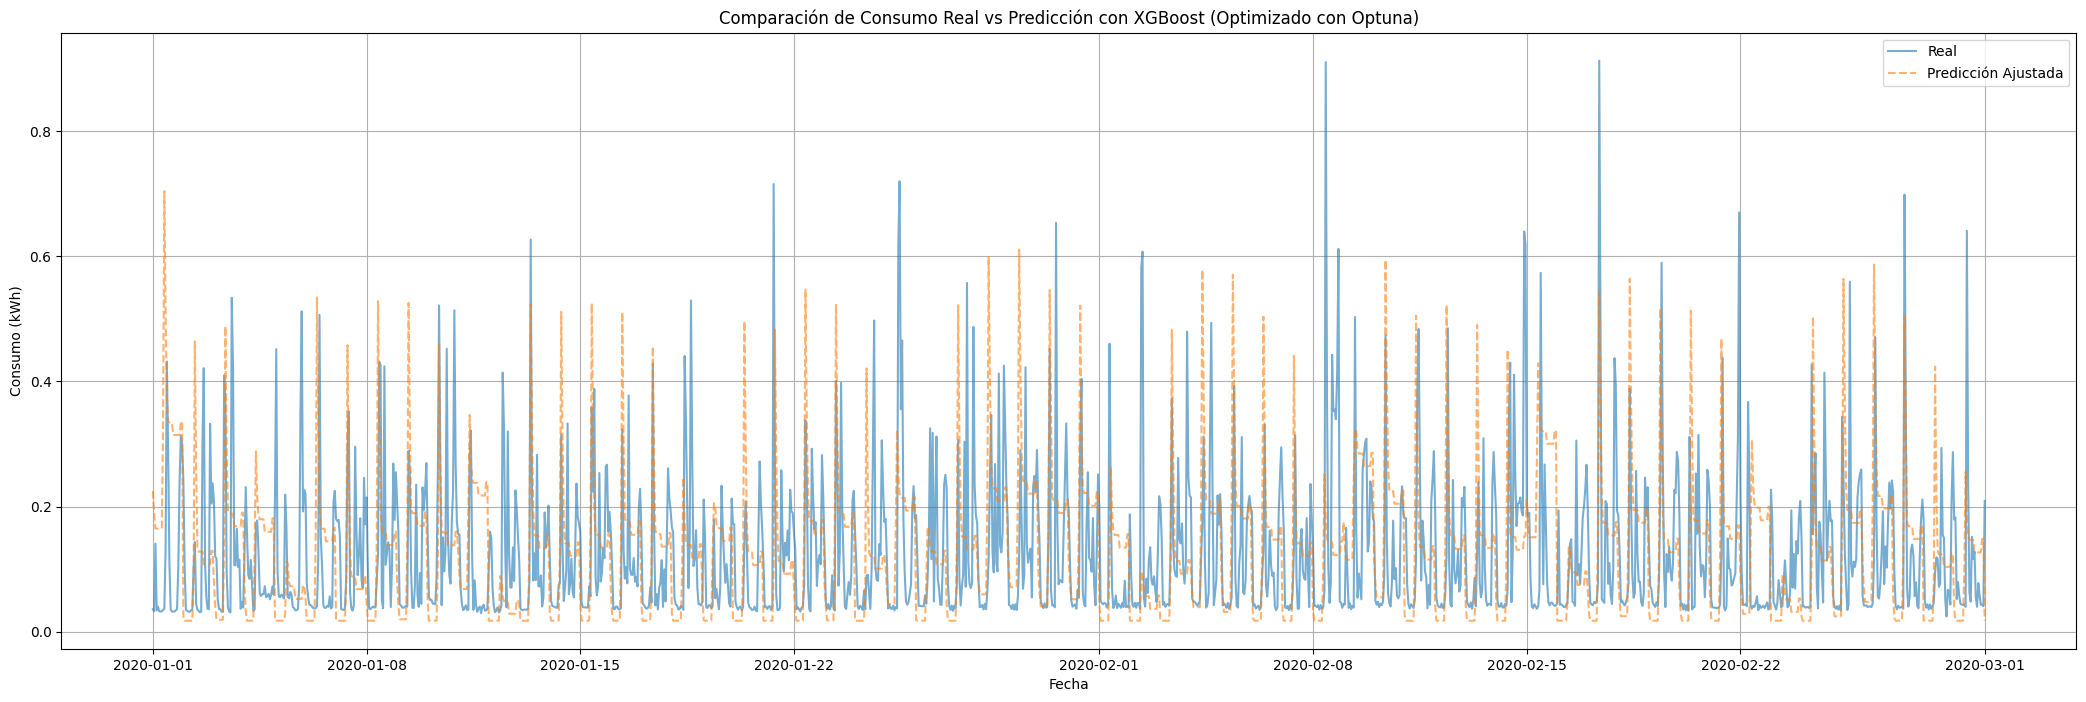

In [11]:

# Graficar los valores reales vs predichos
plt.figure(figsize=(26, 8))
plt.plot(predicciones_totales['timestamp'], predicciones_totales['real'], label="Real", alpha=0.6)
plt.plot(predicciones_totales['timestamp'], predicciones_totales['predicho_ajustado'], label="Predicción Ajustada", linestyle="dashed", alpha=0.6)
plt.xlabel("Fecha")
plt.ylabel("Consumo (kWh)")
plt.title("Comparación de Consumo Real vs Predicción con XGBoost (Optimizado con Optuna)")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
import dagshub
import mlflow
dagshub.init(repo_owner='auditoria.SGBA1', repo_name='Proyectos-SGBA1', mlflow=True)

Accessing as anaigs

Initialized MLflow to track repo "auditoria.SGBA1/Proyectos-SGBA1"

Repository auditoria.SGBA1/Proyectos-SGBA1 initialized!

In [13]:

# Iniciar un nuevo experimento en MLflow
with mlflow.start_run(run_name="xgboost_consumo_individual_optuna") as run:
    run_id = run.info.run_id
    model_name = "XGBoost-Consumo-Hogar"
    model_uri = f"runs:/{run_id}/xgboost_model"

    # Registrar hiperparámetros de XGBoost
    for param, value in best_params.items():
        mlflow.log_param(param, value)

    # Registrar métricas
    mlflow.log_metric("RMSE", rmse_final)
    mlflow.log_metric("MAE", mae_final)

    # Guardar la gráfica
    plot_path = "consumo_vs_prediccion_xgboost.png"
    plt.figure(figsize=(26, 8))
    plt.plot(predicciones_totales['timestamp'], predicciones_totales['real'], label="Real", alpha=0.6)
    plt.plot(predicciones_totales['timestamp'], predicciones_totales['predicho_ajustado'], label="Predicción Ajustada", linestyle="dashed")
    plt.xlabel("Fecha")
    plt.ylabel("Consumo (kWh)")
    plt.title("Comparación de Consumo Real vs Predicción con XGBoost (Optimizado con Optuna)")
    plt.legend()
    plt.grid(True)
    plt.savefig(plot_path)  # Guardar imagen
    plt.close()
    
    mlflow.log_artifact(plot_path)  # Subir imagen a MLflow

    # Guardar y registrar modelo en MLflow
    mlflow.xgboost.log_model(best_model, artifact_path="xgboost_model")

    mlflow.register_model(model_uri=model_uri, name=model_name)

print(f"Modelo registrado en MLflow con run_id: {run_id}")

2025/03/19 20:03:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'XGBoost-Consumo-Hogar'.
2025/03/19 20:03:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-Consumo-Hogar, version 1
Created version '1' of model 'XGBoost-Consumo-Hogar'.


🏃 View run xgboost_consumo_individual_optuna at: https://dagshub.com/auditoria.SGBA1/Proyectos-SGBA1.mlflow/#/experiments/0/runs/52362f1be21e4c47886f2e1b74dd8724
🧪 View experiment at: https://dagshub.com/auditoria.SGBA1/Proyectos-SGBA1.mlflow/#/experiments/0
Modelo registrado en MLflow con run_id: 52362f1be21e4c47886f2e1b74dd8724
